In [1]:
#imports
import networkx as nx
import matplotlib.pyplot as plt

##Preprocessing the data: (Averi)

In [2]:
#Create / Load the network from fb-pages-company.nodes and fb-pages-company.edges

#fb-pages-company.edges contains the edges for the nodes in the graph
#each node is a number stored as a string
#we can use networkx's read_edgelist method to parse the edges file
#the original file has column names (node1, node2) as the first line, so we need to delete that manually before reading the file
graph_companies= nx.read_edgelist("/content/fb-pages-company.edges", delimiter=",")

#check that the graph was loaded in properly by seeing number of nodes and edges
print("Number of nodes:", graph_companies.number_of_nodes())
print("Number of edges:", graph_companies.number_of_edges())
#i noticed that some of the edges have the start and end node as the same node
#ex. on line 52307, the start and end node are both 14056
#not sure if we have to do anything about that, it might affect the degrees?
#could clean the .edges file to look for entries where the start and end nodes are the same and exclude them?

#fb-pages-company.nodes contains an id, name, and new id for each of the company facebook pages
#the new id seems to be the one used in fb-pages-company.edges to identify each node
#so we can add a name attribute for each node so we can better identify it

#node_dict where new id is the key and name is the value
node_names = {}

#parse the nodes file
node_file = open("/content/fb-pages-company.nodes", "r")

#parse the .nodes file so we just have the info we want: the name and new_id
for entry in node_file:
  #some entries have commas in their name, so can't use split method

  #find index of first comma and last comma
  first_comma_index = entry.find(",")
  last_comma_index = entry.rfind(",")

  #substring between these two indexes should be the name
  #have to strip the strings to remove newlines/whitespace at the ends
  company_name = entry[first_comma_index+1:last_comma_index].strip()

  #substring after the last comma should be the new_id
  #have to strip the strings to remove newlines/whitespace at the ends
  id = entry[last_comma_index+1:].strip()

  #put the id and company_name into the dictionary
  #currently both are strings. this is fine, since read_edgelist parsed the nodes as strings instead of integers
  #if the id can be converted into an int, then the string represents an actual number
  #if it can't, print it out to see the offending entry, since it's invalid
  if id.isdigit():
    node_names[id] = company_name
  else:
    print("offending key:",id)
    print("offending val:",company_name)

node_file.close()

#seems like the only entry that isn't valid is the column names since i didn't remove them from the original file
#which is good, because it means the rest are probably valid

#check if the number of nodes in node_names matches the number of nodes in the graph
print("node_names size:",len(node_names))

#they match! so the values in node_names are most likely valid

#for every node in the graph, assign it the corresponding name from fb-pages-company.nodes as a 'name' attribute
nx.set_node_attributes(graph_companies, node_names, "name")


Number of nodes: 14113
Number of edges: 52310
node_names size: 14113


##Getting Dataset Statistics: (Averi)

In [3]:
#What are the number of nodes?
print("Number of nodes:", graph_companies.number_of_nodes())

#What are the number of edges?
print("Number of edges:", graph_companies.number_of_edges())

#What are the number of connected components?
#nx.connected_components(Graph) returns a generator of sets of nodes, where each set is a component
#so convert the generator into a list and get the length of that to see how many components there are
print("Number of connected components:",len(list(nx.connected_components(graph_companies))))

#What is the diameter?
print("Diameter:",nx.diameter(graph_companies))

Number of nodes: 14113
Number of edges: 52310
Number of connected components: 1
Diameter: 15


In [4]:
from networkx.algorithms import approximation
#since there are 14.1K nodes in the graph, networkx's diameter method took 11 minutes
#may be better to use networkx's approximate diameter instead, which is way faster (returned it instantly)
print("Approximate Diameter:",approximation.diameter(graph_companies))

Approximate Diameter: 15


##Degree Distribution Table and Histograms: (Averi)

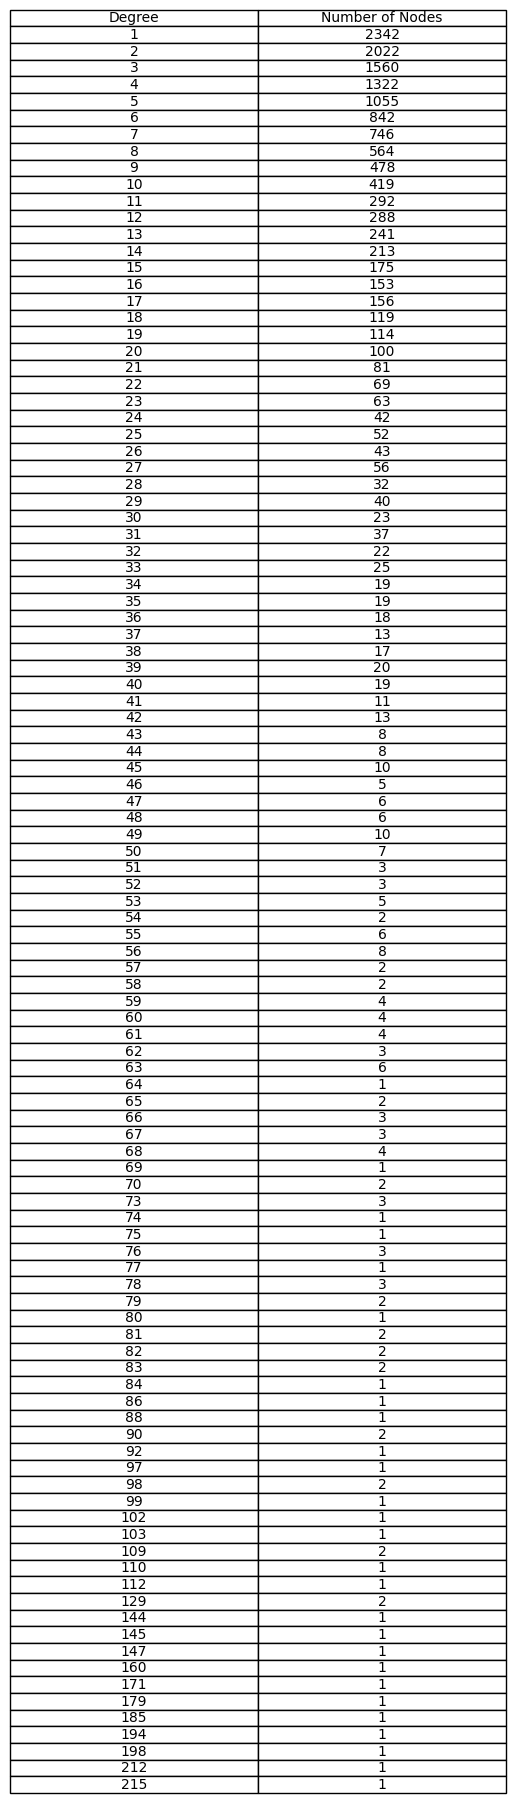

In [5]:
#Degree Distribution

#degrees are the index, values are the number of nodes with that degree
degree_dist = nx.degree_histogram(graph_companies)

#only want the degrees that have at least one node associated with them
degree_dist_list = [[degree, num_of_nodes] for degree, num_of_nodes in enumerate(degree_dist) if num_of_nodes != 0]

#display the table
plt.axis('off')
degree_dist_table = plt.table(cellText=degree_dist_list, loc='center', cellLoc='center', colLabels=['Degree', 'Number of Nodes'])

#the highest degree is 215 and most nodes have very small degrees (1, 2, 3, 4, 5, etc.)

#save the table image
plt.savefig('degree_table.png', bbox_inches = "tight")

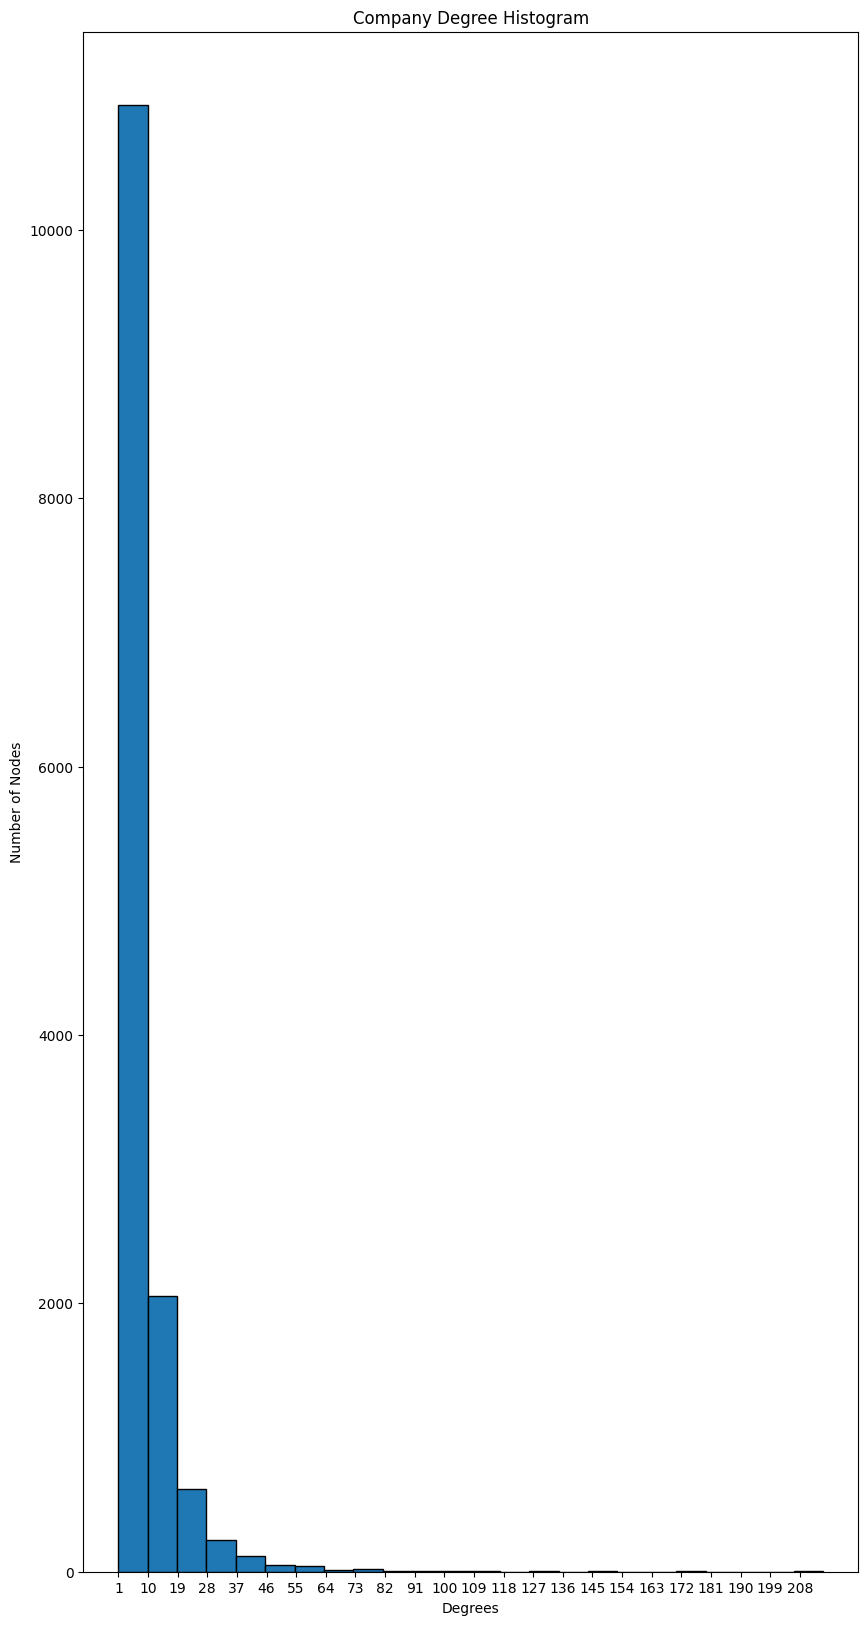

In [6]:
#histogram with different ranges to make it more readable

#Plot the degrees

#get an array of all the degrees
degrees = [graph_companies.degree(node) for node in graph_companies.nodes()]

plt.figure(figsize=(10,20))
plt.xticks(range(1,217, 9))
plt.title("Company Degree Histogram")
plt.xlabel("Degrees")
plt.ylabel("Number of Nodes")

plt.hist(degrees, bins=24, edgecolor="black")

plt.savefig('degree_histogram.png', bbox_inches = "tight")

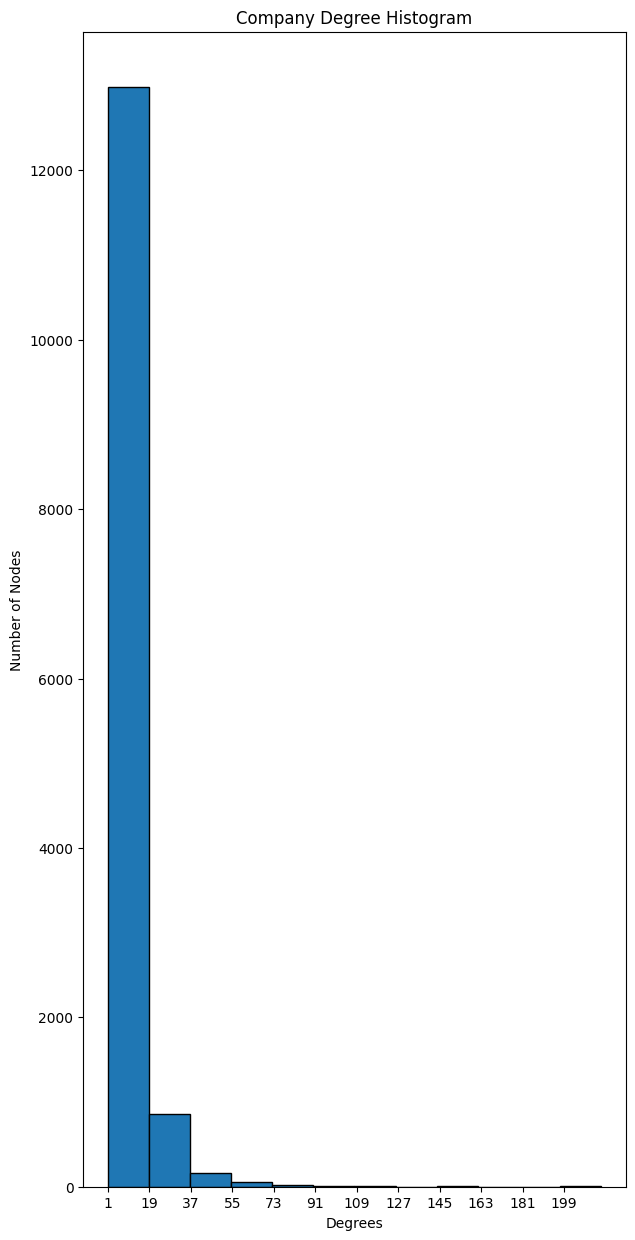

In [7]:
#histogram with different ranges

#Plot the degrees

#get an array of all the degrees
degrees_2 = [graph_companies.degree(node) for node in graph_companies.nodes()]

plt.figure(figsize=(7,15))
plt.xticks(range(1,217, 18))
plt.title("Company Degree Histogram")
plt.xlabel("Degrees")
plt.ylabel("Number of Nodes")

plt.hist(degrees_2, bins=12, edgecolor="black")

plt.savefig('degree_histogram_2.png', bbox_inches = "tight")

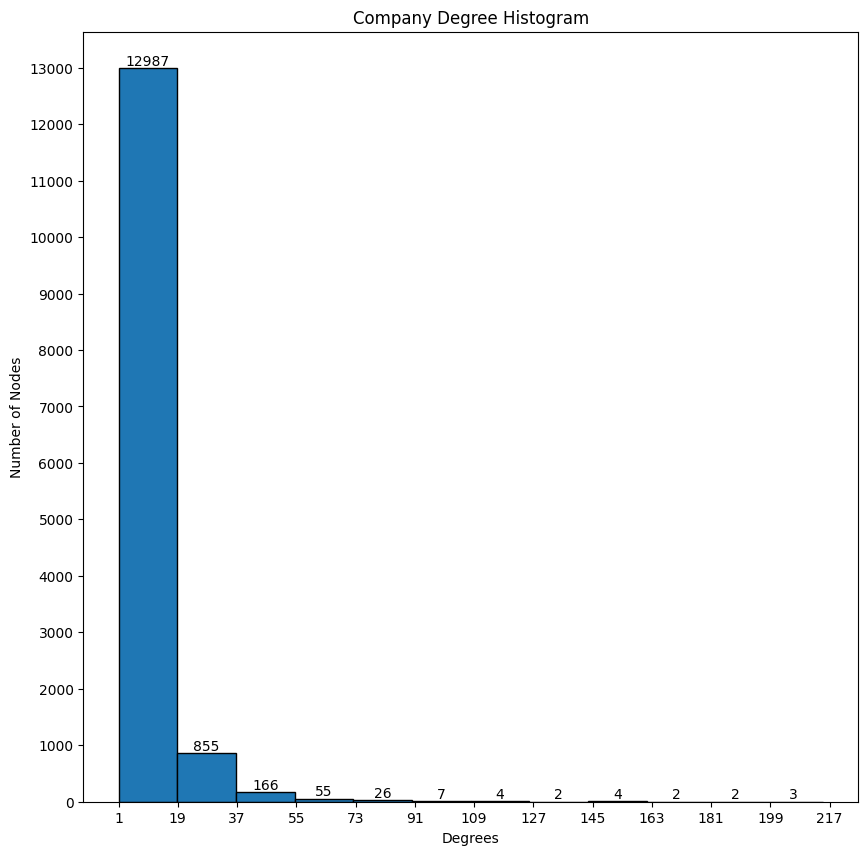

In [8]:
#best looking histogram

#get an array of all the degrees
degrees_3 = [graph_companies.degree(node) for node in graph_companies.nodes()]

plt.figure(figsize=(10,10))
plt.xticks(range(1,218, 18))
plt.yticks(range(0,14000,1000))
plt.title("Company Degree Histogram")
plt.xlabel("Degrees")
plt.ylabel("Number of Nodes")

counts, bins, patches = plt.hist(degrees_3, bins=12, edgecolor="black")
plt.bar_label(patches)

plt.savefig('degree_histogram_3.png', bbox_inches = "tight")

plt.show()

##Normalized Degree, Closeness, Betweenness, Eigenvector Centralities: (Averi)

In [9]:
#Different Centralities (Degree, Closeness, Betweenness, Eigenvector, Katz)
#14.1K nodes, not feasible to display centralities for all nodes
#so instead, just print/display the centralities for the top five of each category

import pandas as pd

#get the nodes and names and put it into a pandas dataframe
#node_names is a dict that has the id as the key and the name as the value
companies_df = pd.DataFrame.from_dict(node_names, orient='index', columns=['Name'])
companies_df.index.names = ['Node']

In [10]:
#Normalized Degree Centralities:
degree_centralities = nx.degree_centrality(graph_companies)
degree_centralities_df = pd.DataFrame.from_dict(degree_centralities, orient='index', columns=['Normalized Degree Centrality'])
degree_centralities_df.index.names = ['Node']

In [11]:
#Normalized Closeness Centralities
closeness_centralities = nx.closeness_centrality(graph_companies)
closeness_centralities_df = pd.DataFrame.from_dict(closeness_centralities, orient='index', columns=['Normalized Closeness Centrality'])
closeness_centralities_df.index.names = ['Node']

In [12]:
#Normalized Betweenness Centralities
betweenness_centralities = nx.betweenness_centrality(graph_companies)
betweenness_centralities_df = pd.DataFrame.from_dict(betweenness_centralities, orient='index', columns=['Normalized Betweenness Centrality'])
betweenness_centralities_df.index.names = ['Node']

In [13]:
#Normalized Eigenvector Centralities
eigenvector_centralities = nx.eigenvector_centrality(graph_companies)
eigenvector_centralities_df = pd.DataFrame.from_dict(eigenvector_centralities, orient='index', columns=['Normalized Eigenvector Centrality'])
eigenvector_centralities_df.index.names = ['Node']

In [14]:
#concat all the dataframes together
all_centralities = pd.concat([companies_df, degree_centralities_df, closeness_centralities_df, betweenness_centralities_df, eigenvector_centralities_df], axis=1)

In [15]:
#Note: It took 41 minutes for the above code section to run
#since there are a lot of nodes and closeness/betweenness centralities take a long time for networkx to calculate
#but at least it does work

#print out the all_centralities dataframe
all_centralities

,Name,Normalized Degree Centrality,Normalized Closeness Centrality,Normalized Betweenness Centrality,Normalized Eigenvector Centrality
Node,,,,,
11192,ALDI Australia,0.000779,0.206108,0.000153,3.396694e-05
10743,Wetpaint,0.000142,0.206243,0.000010,2.276155e-05
13087,Q102.7 KBIQ,0.000283,0.222023,0.000284,6.616704e-05
12630,"""Paraná TV, Bom Dia PR e G1 PR""",0.000071,0.133025,0.000000,2.540310e-09
7453,easyJet,0.000709,0.191469,0.000001,7.426508e-06
...,...,...,...,...,...
5367,Hay House,0.000425,0.222587,0.000124,1.082044e-04
12638,Sunday Kiss,0.000283,0.184273,0.000002,4.194150e-06
8695,American Express,0.000071,0.145839,0.000000,2.365385e-08


##Top 5 Nodes For Each Centrality: (Averi)

In [16]:
#Top Five Company Pages Based On Normalized Degree Centrality
#sort the all_centralities dataframe by Normalized Degree Centrality in descending order
#take the top five rows and the name/normalized degree centrality columns
top_five_degree_centralities = all_centralities.sort_values(by=["Normalized Degree Centrality"], ascending=False).head(5)[['Name', 'Normalized Degree Centrality']]
top_five_degree_centralities

#What are the five nodes with the highest normalized degree centrality?
#CNN (id=8396): ~0.015235
#Starbucks (id=11934): ~0.015023
#Facebook (id=856): ~0.014031
#Mashable (id=11380): ~0.013747
#Red Bull (id=9886): ~0.013109

,Name,Normalized Degree Centrality
Node,,
8396,CNN,0.015235
11934,Starbucks,0.015023
856,Facebook,0.014031
11380,Mashable,0.013747
9886,Red Bull,0.013109


In [17]:
#Normalized Closeness Centralities:
top_five_closeness_centralities = all_centralities.sort_values(by=["Normalized Closeness Centrality"], ascending=False).head(5)[['Name', 'Normalized Closeness Centrality']]
top_five_closeness_centralities

#What are the five nodes with the highest normalized closeness centrality?
#CNN (id=8396): ~0.291366
#Mashable (id=11380): ~0.286637
#BuzzFeed (id=1237): ~0.283334
#Origin Magazine. (id=786): ~0.282664
#BBC News (id=8223): ~0.280752

,Name,Normalized Closeness Centrality
Node,,
8396,CNN,0.291366
11380,Mashable,0.286637
1237,BuzzFeed,0.283334
786,Origin Magazine.,0.282664
8223,BBC News,0.280752


In [18]:
#Normalized Betweenness Centralities:
top_five_betweenness_centralities = all_centralities.sort_values(by=["Normalized Betweenness Centrality"], ascending=False).head(5)[['Name', 'Normalized Betweenness Centrality']]
top_five_betweenness_centralities

#What are the five nodes with the highest normalized betweenness centrality (node betweenness)?
#Red Bull (id=9886): ~0.056949
#BBC News (id=8223): ~0.051127
#CNN (id=8396): ~0.049576
#Facebook (id=856): ~0.044892
#Mashable (id=11380): ~0.042105

,Name,Normalized Betweenness Centrality
Node,,
9886,Red Bull,0.056949
8223,BBC News,0.051127
8396,CNN,0.049576
856,Facebook,0.044892
11380,Mashable,0.042105


In [19]:
#Normalized Eigenvector Centralities
top_five_eigenvector_centralities = all_centralities.sort_values(by=["Normalized Eigenvector Centrality"], ascending=False).head(5)[['Name', 'Normalized Eigenvector Centrality']]
top_five_eigenvector_centralities

,Name,Normalized Eigenvector Centrality
Node,,
4596,Sveriges Radio,0.231865
10503,zbNOW/早报现在,0.214485
4535,P4 Jämtland Sveriges Radio,0.199841
12970,Karlavagnen i Sveriges Radio P4,0.182781
1229,P4 Västernorrland Sveriges Radio,0.182738


##Top 5 Nodes For Clustering Coefficient: (Averi)

In [20]:
#Clustering Coefficient

#get the nodes and names and put it into a pandas dataframe
#node_names is a dict that has the id as the key and the name as the value
companies_df_2 = pd.DataFrame.from_dict(node_names, orient='index', columns=['Name'])
companies_df_2.index.names = ['Node']

#get dictionary of the clustering coefficients and turn it into a dataframe
clustering_coefficients_dict = nx.clustering(graph_companies)
clustering_coefficients_df = pd.DataFrame.from_dict(clustering_coefficients_dict, orient='index', columns=['Clustering Coefficient'])

#combine the two dataframes
companies_clustering_df = pd.concat([companies_df_2, clustering_coefficients_df], axis=1)

#get the nodes with a clustering coefficient of 1
top_clustering_coefficients = companies_clustering_df[companies_clustering_df['Clustering Coefficient'] == 1]

top_clustering_coefficients
#based on this there are 925 nodes that have a clustering coefficient of 1, which is the highest possible value

#get five nodes with the highest clustering coefficients
top_five_clustering_coefficients = companies_clustering_df.sort_values(by=["Clustering Coefficient"], ascending=False).head(5)[['Name', 'Clustering Coefficient']]
top_five_clustering_coefficients

#What are the five nodes with the highest clustering coefficients?
#there are 925 nodes that have the max clustering coefficient of 1
#so five random nodes that have a clustering coefficient of 1 are:
#Verizon Enterprise (id=8387): 1
#"S.M. C&C (예능, MC매니지먼트)" (id=9532): 1
#105.1 The River (id=4631): 1
#Liverpool FC - Liverpool Echo (id=9321): 1
#Claro Guatemala (id=5223): 1

,Name,Clustering Coefficient
8387,Verizon Enterprise,1.0
9532,"""S.M. C&C (예능, MC매니지먼트)""",1.0
4631,105.1 The River,1.0
9321,Liverpool FC - Liverpool Echo,1.0
5223,Claro Guatemala,1.0


##Average Clustering Coefficient For Whole Graph: (Averi)

In [21]:
#takes average of Clustering Coefficient column
companies_clustering_df["Clustering Coefficient"].mean()

0.23924183803998195

##Next Highest Clustering Coefficients Less Than One: (Averi)

In [22]:
#filters dataframe for coefficients less than one
less_than_one = companies_clustering_df[companies_clustering_df['Clustering Coefficient'] < 1]
#get the top 5 clustering coefficients less than 1
less_than_one.sort_values(by=["Clustering Coefficient"], ascending=False).head(10)[['Name', 'Clustering Coefficient']]

,Name,Clustering Coefficient
10089,Lidl Malta,0.992647
9926,Lidl Bulgaria,0.992647
9547,Lidl Česká republika,0.992647
11670,Messaggero Veneto,0.990476
573,Gazzetta di Modena,0.990476
11533,WD,0.987179
8334,FOCUS Online Immobilien,0.977941
12056,Junior Mints,0.977778
8814,Charms Blow Pops,0.977778
4367,Sugar Babies,0.977778


##Which Company Has The Highest Degree?: (Averi)

In [23]:
#Which company page has the highest degree?

#get an array of degrees
degrees_array = [graph_companies.degree(node) for node in graph_companies.nodes()]
#get dictionary of degrees using dictionary comprehension
degrees_dict = {node:graph_companies.degree(node) for node in graph_companies.nodes()}

#set the degree as a node attribute
nx.set_node_attributes(graph_companies, degrees_dict, "degree")

#loop through all the nodes,
#if the degree attribute is equal to max(degrees_array), then print out the name of the company
for node in graph_companies.nodes():
  if graph_companies.nodes[node]["degree"] == max(degrees_array):
    print("Company with highest degree:",graph_companies.nodes[node]["name"])

#seems like the company with the highest degree is CNN
#which i guess makes sense, since it's a major news channel

Company with highest degree: CNN


##Matplotlib/Networkx Visualization: (Vivekanand)

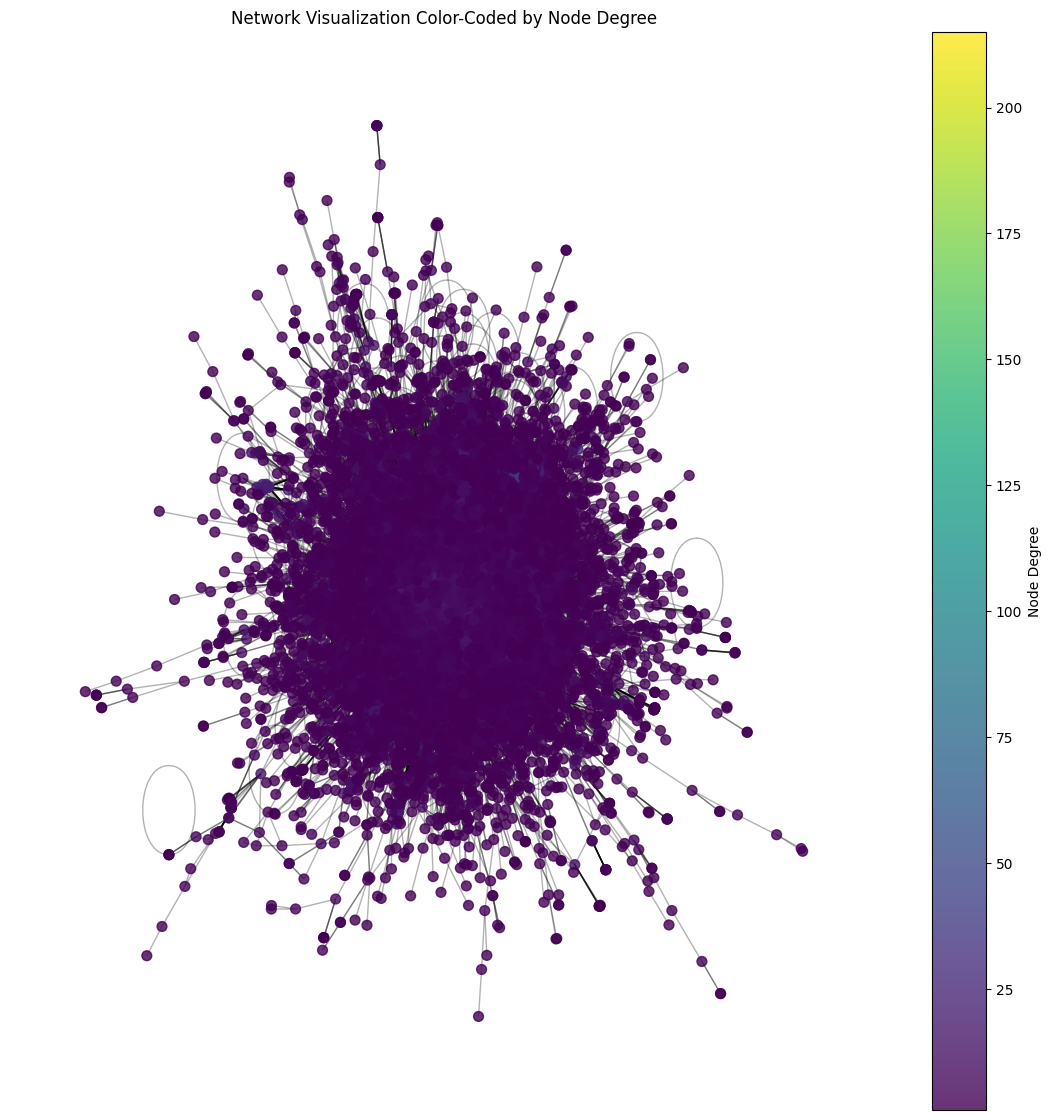

In [24]:
#Various Visualizations of the Network
#Should introduce color

#In addition to a general visualization of all nodes in the network,
#Maybe can have a visualization where each node is color coded based on the number of degrees it has?
import matplotlib.pyplot as plt
import networkx as nx

# Calculate degrees for each node
node_degrees = dict(graph_companies.degree())
# Get a list of degrees for color mapping
degree_values = list(node_degrees.values())

# Generate color map based on degree values
# Here, 'viridis' is used as the color map, which goes from dark to light
# Colors can be changed by selecting a different cmap from matplotlib
cmap = plt.cm.viridis

# Create a figure for the plot
plt.figure(figsize=(14, 14))

# Draw the network
pos = nx.spring_layout(graph_companies, seed=42)  # Using spring layout for clear visualization
nodes = nx.draw_networkx_nodes(
    graph_companies,
    pos,
    node_size=50,
    node_color=degree_values,
    cmap=cmap,
    alpha=0.8
)
edges = nx.draw_networkx_edges(graph_companies, pos, alpha=0.3)

# Add a color bar to show degree scaling
cbar = plt.colorbar(nodes)
cbar.set_label("Node Degree")

# Remove labels and axis for clarity
plt.axis('off')
plt.title("Network Visualization Color-Coded by Node Degree")
plt.show()


##Link Prediction: (Elias)

Link Prediction:

Professor Given Code for Link Prediction: https://colab.research.google.com/drive/1fVLZM-Q0bGbw5Xxg1FknmWOQkXO8NeJH?usp=sharing


In [25]:
#link prediction

In [26]:
import random

# Define the proportion of edges to remove (e.g., 25%)
edge_subset = random.sample(graph_companies.edges(), int(0.25 * graph_companies.number_of_edges()))

# Create a training graph by removing the selected edges
graph_companies_train = graph_companies.copy()
graph_companies_train.remove_edges_from(edge_subset)


<ipython-input-26-8d4cbd9a2f77>:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  edge_subset = random.sample(graph_companies.edges(), int(0.25 * graph_companies.number_of_edges()))


**Jaccard Coefficient**

In [27]:
# Jaccard Coefficient Prediction
prediction_jaccard = nx.jaccard_coefficient(graph_companies_train, edge_subset)
score, label = zip(*[(s, (u, v) in edge_subset) for (u, v, s) in prediction_jaccard])

# Apply a threshold to determine which edges are predicted as links
threshold = 0.2
predicted_edges = sum(s > threshold for s in score)
predicted_jaccard_accuracy = predicted_edges / len(edge_subset)
print("Jaccard Coefficient Accuracy:", predicted_jaccard_accuracy)


Jaccard Coefficient Accuracy: 0.17916953429685709


The Jaccard Coefficient method measures the similarity between two nodes based on their shared neighbors. A high Jaccard score suggests that two nodes have a similar "local neighborhood." However, in large complex networks like this one (network of FB-pages)
This method might not be very predictive because relationships are often not based solely on shared connections.

**Preferential Attachment**

In [28]:
# Preferential Attachment Prediction
prediction_common_neighbor = nx.preferential_attachment(graph_companies_train, edge_subset)
score2, label2 = zip(*[(s, (u, v) in edge_subset) for (u, v, s) in prediction_common_neighbor])

# Apply threshold
threshold_pa = 15
predicted_edges2 = sum(s > threshold_pa for s in score2)
predicted_pa_accuracy = predicted_edges2 / len(edge_subset)
print("Preferential Attachment Accuracy:", predicted_pa_accuracy)


Preferential Attachment Accuracy: 0.774260151410874


The Preferential Attachment method predicts links based on the idea that nodes with higher degrees are more likely to form new links. In networks with “hub-like” behavior, such as social or collaborative networks, this assumption often holds because popular nodes tend to attract more connections.

##Girvan-Newman Communities: (Elias)

**Communities**

**Girvan-Newman**


In [29]:
#Communities

#What are the edges that would be removed using Girvan-Newman algorithm...
#...when splitting the given graph with N components into components?

import networkx as nx
from networkx.algorithms.community import girvan_newman, modularity_max

# Subsample a random subset of nodes bc with all nodes Girvan-Newman is too time consuming
sampled_nodes = random.sample(graph_companies.nodes(), 1000)
sampled_graph = graph_companies.subgraph(sampled_nodes).copy()

communities = girvan_newman(sampled_graph)
top_level_communities = next(communities)
community_list = sorted(map(sorted, top_level_communities))

# Get community sizes along with each community
community_sizes = [(len(community), community) for community in community_list]

# Sort communities by size in descending order
sorted_communities = sorted(community_sizes, key=lambda x: x[0], reverse=True)

# Select only the top 10 largest communities
top_ten_communities = sorted_communities[:10]

# Display the top 10 communities with their sizes and company names
for i, (size, community) in enumerate(top_ten_communities, start=1):
    print(f"Community {i} (Size: {size})")
    # Get company names for each node in the community
    company_names = [node_names[node] if node in node_names else "" for node in community]
    print("Companies:", company_names)
    print()

<ipython-input-29-bbc7b8eb65ff>:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(graph_companies.nodes(), 1000)


Community 1 (Size: 20)
Companies: ['Microsoft', 'MarTech Conference', 'ORF III', 'Microsoft Edge', 'PENNY', '24sata', 'hhgregg', "Omi's Apfelstrudel", 'Microsoft', 'Microsoft', 'Microsoft', 'SPAR Österreich', 'Pam Panorama', 'Antenne Steiermark', 'Panamericana', 'Showroomprive', 'Lenovo United States', 'Microsoft', 'Microsoft Developer', 'Opinion Leaders Network']

Community 2 (Size: 18)
Companies: ['IZZE', '104-5 KDAT', 'DVF - Diane von Furstenberg', 'Bump Club and Beyond', 'FEED Projects', 'Healthy Choice', 'TerraCycle', 'Meals With Kraft', 'Made in China', 'Fifty One East', '"Babies""R""Us"', 'Cole Haan', 'Flake', 'Dannijo', 'Flake', 'Stuart Weitzman', 'Wholly Guacamole', "Beef. It's What's For Dinner."]

Community 3 (Size: 11)
Companies: ['Bloomberg', 'UPS', 'UPS', 'WDRB News', 'Netflix', 'Maria Neider', 'Tigo Paraguay', 'Tigo Bolivia', 'Real Clear Future', 'RealClearWorld', 'Netflix']

Community 4 (Size: 7)
Companies: ['Koreaboo', 'GIORDANO', 'Time Out Singapore', 'The Goods San D